In [1]:
%pylab inline
from math import gcd as GCD
from scipy.sparse.coo import coo_matrix as sparsemat
from scipy.sparse.linalg import svds as sparsesvd
from itertools import combinations
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
def decimal_to_state(m,nqubit):
    '''
        Return binary representation of m as array of nqubit qubits

            Parameters
            ----------                
            m:   Integer
                number to be representend in binary form
                
            nqubit: Integer
                Total number of qubits used for representation
                    
    '''
    
    arr=binary_repr(m)
    arr=[int(i) for i in arr]
    if(len(arr)>nqubit):
        raise ValueError(str(nqubit)+" are not enough qubits to store the number "+str(m))
    if(len(arr)==nqubit): return arr
    return list(np.zeros(nqubit-len(arr),dtype=int16))+ arr


def to_decimal(array):
    '''
        Return decimal representation of the array storing a number in binary form

        Example: input [1,0,1,0,1] returns 21 
            Parameters
            ----------                
            array: List
                array containing binary representation of a number
                
                    
    '''

    size=len(array)
    return int(np.sum([array[i] *2**(size-i-1)  for i in range(size)]))

def find_coprime(N):     
    """
            Find a coprime of N for N>2
            Parameters
            ----------
            N:  Integer
                Number to find the coprime of

    """
    if(N<3):
        raise ValueError("Illegal argument: coprimes exist for N>2")
    Y=randint(2,N)
    used=[]
    while 1:
        a=GCD(Y,N)
        if (a>1):
            #this Y is not coprime
            used.append(Y)
            while(Y in used):
                Y=randint(2,N)
        else: return Y

In [6]:
def notchosen(chosen,system_size):
    """
            Return array containing the qubit NOT in the partition
            
            Parameters
            ----------                
            chosen:   List
                List of the qubits selected as partition, in the form [1,3,7,..]
                
            system_size: Integer
                Total number of qubits
                    
    """
    
    notchosen=list(set(list(range(system_size)))-set(chosen))
    notchosen.sort()
    return notchosen

def create_W(k,Y,N,chosen):
    '''
    creates W directly
    
    '''
    
    L=int(ceil(log2(N)))
    if(k>2*L):
        raise ValueError(str(k)+"th computational step does not make sense in a "+str(2*L)+" qubits control register")
    
    #nonzero elements of psi in binary form
    nonzeros=[decimal_to_state(m*2**L+(Y**m%N),k+L) for m in range(2**k)]
    not_chosen=notchosen(chosen,k+L)  

    indexes=[ (to_decimal(split_components(i,chosen)),to_decimal((split_components(i,not_chosen)))) for i in nonzeros]
    row=[elem[0] for elem in indexes]
    col=[elem[1] for elem in indexes]
    data=np.ones(2**k)/sqrt(2**k)
    
    return sparsemat((data,(row,col)), shape=(2**len(chosen),2**len(not_chosen))    ).tocsc()

def split_components(array,chosen):
    '''
    Given an input array and selected components returns two arrays.
    The first array contains only the chosen components and the other the remainders
    '''
    if( max(chosen) not in range(len(array)))  :
        raise ValueError('the chosen '+str(max(chosen))+' bit is not present in a '+str(len(array))+' bits register')
    return [array[i] for i in chosen]


def entanglement_entropy(k,Y,N,chosen):
    global W_time
    t0=time.clock()
    W=create_W(k,Y,N,chosen)
    W_time.append(time.clock()-t0)
    
    global svd_time
    t0=time.clock()
    eigs=sparsesvd(W,k=min(shape(W))-1,which='LM',return_singular_vectors=False)
    eigs=eigs*eigs
    entr=-np.sum([i*np.log2(i) for i in eigs if i>0])
    
    svd_time.append(time.clock()-t0)
    return entr

In [7]:
N=10
L=int(ceil(log2(N)))
#Y=find_coprime(N)
#print(Y)
Y=7 #N,Y=(3,2),(6,5),(10,7),(11,8),(21,17), (64,57)

In [8]:
%%time
#times:
#for all ks: (3..4,76 ms), (5..8,800 ms)
#      19 sec for N=9,..,16, 540s for N=17,..,32, not feasible for N=33,..,64

W_time=[]
svd_time=[]

entropy=[entanglement_entropy(k,Y,N,chosen) for k in range(1,2*L+1) for chosen in combinations(range(k+L),int((k+L)/2))]

#entropy[0] will contain all computational steps of first chosen partition

/home/simone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/simone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/simone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/simone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


CPU times: user 3min 16s, sys: 5.79 s, total: 3min 22s
Wall time: 1min 58s


147.15137000000038 54.93174200000061


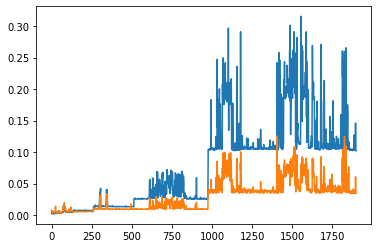

In [9]:
plot(range(len(W_time)),[i for i in W_time])
plot(range(len(svd_time)),[i for i in svd_time])
print(sum(W_time),sum(svd_time))

In [17]:
%%time
#for fixed max k (3..4,54 ms), (5..8,500 ms)
#      14 sec for N=9,..,16, 380 s for N=17,..,32, not feasible for N=33,..,64
k=2*L
entropy=[entanglement_entropy(k,Y,N,chosen) for chosen in combinations(range(k+L),int((k+L)/2))]

CPU times: user 2.59 s, sys: 3.65 ms, total: 2.59 s
Wall time: 2.59 s


/home/simone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


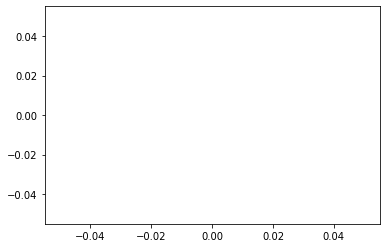

In [19]:
x=np.arange(0,2)
y= x/(1-x)
plot(x,y)